# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd /Users/rushikesh/python_files/vscode/transformer/src/main/python/

/Users/rushikesh/python_files/vscode/transformer/src/main/python


In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

torch.set_printoptions(
    precision=2,     # number of decimals
    linewidth=120,   # max characters per line
    sci_mode=False   # disable scientific notation
)


In [4]:
loss_fn = torch.nn.CrossEntropyLoss()

from utils.Embeddings.Embeddings import Embeddings
from utils.Attention.Attention import attentionLayer
from utils.Attention.Attention import multiHeads
from utils.Attention.Attention import residualConnection
from utils.FFN.FFN import feedForward
from utils.Tokenizer.Tokenizer import SimpleTokenizer
from utils.LayerNorm.LayerNorm import LayerNorm



# Data

In [5]:
with open("data/Text.txt", 'r') as f:
    text = f.read()

In [6]:
words = text.lower().split(" ")

In [7]:
import re

def clean_words(word_list):
    cleaned = []
    for word in word_list:
        word_lower = word.lower()  # convert to lowercase
        if re.fullmatch(r"[a-z]+", word_lower) and (len(word_lower) >=4) and (len(word_lower) <= 8) :
            cleaned.append(word_lower)
    return cleaned


In [8]:
words = clean_words(words)

In [9]:
print("Some words from the training data")
print(words[:5])

Some words from the training data
['march', 'reddits', 'before', 'even', 'started']


In [10]:
all_words = words.copy()

new_words = []
seven_letter_count = 0
data = []

for w in words:
    if len(w) == 7:
        seven_letter_count += 1
        if seven_letter_count < 10000:
            new_words.append(w)   
        else:
            data.append(w) # keep from 10000th onward
    else:
        new_words.append(w)       # keep non-7-letter words

# Replace words
words = new_words


In [11]:
import random

def prepare_training_example(word, tokenizer, max_len=8, mask_prob=0.5):
   
    padded_word = list(word) + ['<e>' for i in range(max_len - len(word))]

    x_chars = padded_word[::]

    for i in range(len(x_chars)):
        if x_chars[i] != '<e>' and (x_chars[i] != '<s>') and random.random() < mask_prob:
            x_chars[i] = '<mask>'
    
    x_encoded = tokenizer.encode(x_chars, pad=True)

    candidates = [i for i in range(len(x_chars)) if ((x_chars[i] not in ['<e>', '<s>']) & (x_chars[i] == '<mask>'))]

    y_chars = list(x_chars)

    if candidates:

        idx = random.choice(candidates)
        
        y_chars[idx] = padded_word[idx]

    y_encoded = tokenizer.encode(list(y_chars), pad=True)
    
    return x_encoded, y_encoded



In [12]:
sequence   = 'mango'

Tokenizer  = SimpleTokenizer(list('abcdefghijklmnopqrstuvwxyz'))

x          = Tokenizer.encode(sequence, pad = True)


print("Example usage of the simple encoder")

print(f"Original word: {sequence}")

print(f"Tokenized word: {x}")

Example usage of the simple encoder
Original word: mango
Tokenized word: tensor([[ 0, 13,  1, 14,  7, 15, 27]])


In [13]:
import random


X, Y = [], []
x_before, y_before =  None, None

for word in words:
    # Choose a random mask probability for this example
    mask_prob = random.uniform(0.1, 0.9)  # e.g., 10% to 80% masked
    u = random.random()
    # mask_prob = 0.05 + (0.8 - 0.1) * (1 - u**2)  # favor smaller mask fraction

    for _ in range(50):
    
        x, y = prepare_training_example(word, Tokenizer, max_len=8, mask_prob=mask_prob)

        if (x_before != None) and torch.all((x_before == x) & (y_before == y)):

            continue
        
        X.append(x)

        Y.append(y)

        x_before, y_before = x, y


In [14]:
idx = 330
print(f"Example word: {words[idx]}\n")

print(f"Input sequence:  {X[idx].squeeze()}")
print(f"Decoded Input sequence:  {"".join(Tokenizer.itos[i] for i in X[idx].squeeze().numpy())}\n")


print(f"Target sequence:  {Y[idx].squeeze()}")
print(f"Decoded Target sequence:  {"".join(Tokenizer.itos[i] for i in Y[idx].squeeze().numpy())}")



Example word: could

Input sequence:  tensor([ 0, 20, 28, 28, 28, 27, 27, 27, 27, 27])
Decoded Input sequence:  <s>t<mask><mask><mask><e><e><e><e><e>

Target sequence:  tensor([ 0, 20, 28, 28, 25, 27, 27, 27, 27, 27])
Decoded Target sequence:  <s>t<mask><mask>y<e><e><e><e><e>


# Model

In [15]:
# --- prepared training examples ---
# X: list of tensors (B, T)
# Y: list of tensors (B, T)
# Convert to tensors
X_tensor = torch.stack(X)  # shape: (B, T)
Y_tensor = torch.stack(Y)  # shape: (B, T)

X_tensor.shape, Y_tensor.shape

(torch.Size([4370978, 1, 10]), torch.Size([4370978, 1, 10]))

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


# --- Hyperparameters ---
seq_len    = 10 ## max word lenght = 8 + 2 tokens (start and end)
vocab_size = 29 ## 26 alphabets + (start, end and mask)
d_model    = 36
num_epochs = 10000
learning_rate = 0.005


emb        = Embeddings(vocab_size = vocab_size, d_model= d_model, max_len= seq_len)

multiHeadLayer = multiHeads(num_heads = 3, 
                            d_model   = d_model, 
                            max_len   = seq_len)
rc = residualConnection()
FFN = feedForward(d_model = d_model, max_len = seq_len, vocab_size = vocab_size)
L1  = LayerNorm(d_model, seq_len)

# --- Loss and optimizer ---
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(emb.parameters() +
                       multiHeadLayer.parameters() +
                       FFN.parameters() + L1.parameters(),
                       lr=learning_rate)



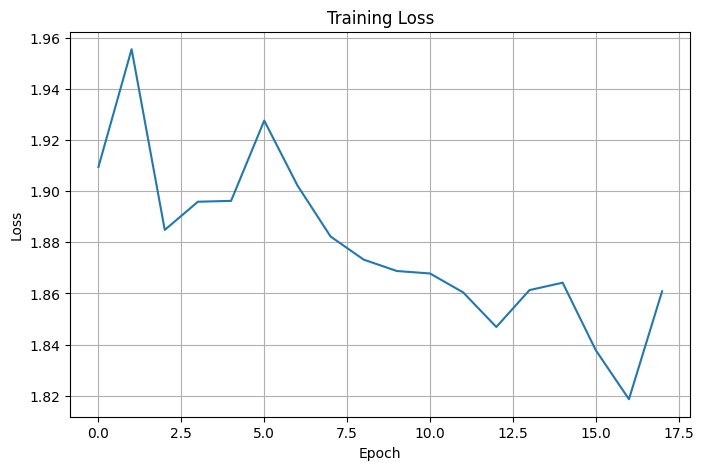

KeyboardInterrupt: 

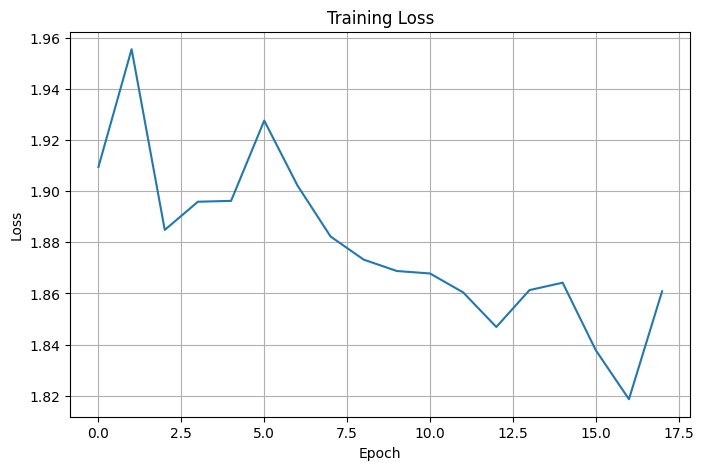

In [19]:

# --- Training loop ---

fig, ax = plt.subplots(figsize=(8,5))
display(fig)

loss_history = []
learning_rate = 0.015


for epoch in range(num_epochs):
    optimizer.zero_grad()

    idx  = random.sample(range(len(words)), 5000)

    X_idx = X_tensor[idx].squeeze(1)
    Y_idx = Y_tensor[idx].squeeze(1)

    
    # Forward pass
    x0 = emb(X_idx)
    x1 = multiHeadLayer(x0)
    x2 = rc(x0, x1)
    x3 = L1(x2)
    x4 = FFN(x3)
    logits = x4
    targets = Y_idx
    ## Loss on all tokens -------- OPTION A
    
    
    
    # # Compute loss
    # loss = loss_fn(
    #     logits.view(-1, logits.size(-1)),  # (B*T, V)
    #     targets.view(-1)                    # (B*T)
    # )

    ## Loss on just revealed mask ------ OPTION B

    mask = (X_idx == 28) & (Y_idx <= 26)

    mask_flat = mask.view(-1)

    masked_logits = logits.view(-1, logits.size(-1))[mask_flat]
    masked_targets = targets.view(-1)[mask_flat]

    loss = loss_fn(masked_logits, masked_targets)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        if loss.item() < 4:
            loss_history.append(loss.item())

            ax.clear()
            ax.plot(loss_history)
            ax.set_title("Training Loss")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            ax.grid(True)

            clear_output(wait=True)
            display(fig)



In [21]:
print(f"final training loss: {loss_history[-1]}")

final training loss: 1.9636609554290771


In [23]:
import torch
import torch.nn.functional as F

def predict_probabilistic(emb, multiHeadLayer, rc, L1, FFN, x_single, temperature=1.0):
    x = x_single.unsqueeze(0)

    x0 = emb(x)
    x1 = multiHeadLayer(x0)
    x2 = rc(x0, x1)
    x3 = L1(x2)
    logits = FFN(x3)

    mask = (x == 28).squeeze(0)

    preds = []
    for i in range(len(mask)):
        if mask[i]:
            token_logits = logits[0, i] / temperature
            probs = F.softmax(token_logits, dim=-1)
            pred_id = torch.multinomial(probs, 1).item()
            preds.append(pred_id)
        else:
            preds.append(x_single[i].item())

    return torch.tensor(preds)


In [24]:
idx = 307

print("Example word:", words[idx])
print("Input sequence: ", X[idx].squeeze())
print("Decoded input:  ", "".join(Tokenizer.itos[i] for i in X[idx].squeeze().numpy()))
print()

pred_ids = predict_probabilistic(emb, multiHeadLayer, rc, L1, FFN, X_tensor[idx].squeeze())
print("Predicted seq: ", pred_ids)
print("Decoded prediction:", "".join(Tokenizer.itos[i] for i in pred_ids.numpy()))


Example word: user
Input sequence:  tensor([ 0,  3, 28, 28, 28, 27, 27, 27, 27, 27])
Decoded input:   <s>c<mask><mask><mask><e><e><e><e><e>

Predicted seq:  tensor([ 0,  3,  1,  1, 19, 27, 27, 27, 27, 27])
Decoded prediction: <s>caas<e><e><e><e><e>


# Performance

In [20]:
def build_input_sequence(secret_word, correct):
    """
    correct: list of correctly guessed characters
    """
    seq = []
    for ch in secret_word:
        if ch in correct:
            seq.append(Tokenizer.stoi[ch])
        else:
            seq.append(28)  # mask
    return torch.tensor(seq, dtype=torch.long)


import torch.nn.functional as F

def get_letter_from_model(secret_word, missed, correct,
                          emb, multiHeadLayer, rc, L1, FFN):
    x_single = build_input_sequence(secret_word, correct)
    x = x_single.unsqueeze(0)  # (1, seq_len)

    with torch.no_grad():
        x0 = emb(x)
        x1 = multiHeadLayer(x0)
        x2 = rc(x0, x1)
        x3 = L1(x2)
        logits = FFN(x3)  # (1, seq_len, vocab)

    mask_positions = (x_single == 28)

    # Sum logits over masked positions
    letter_logits = torch.zeros(logits.size(-1))
    for i in torch.where(mask_positions)[0]:
        letter_logits += logits[0, i]

    probs = F.softmax(letter_logits, dim=0)

    # Avoid guessing already tried letters
    tried = set(missed + correct)
    for ch in tried:
        probs[Tokenizer.stoi[ch]] = 0.0

    probs = probs / probs.sum()  # renormalize

    guess_id = torch.argmax(probs).item()
    return Tokenizer.itos[guess_id]


def simulate_hangman_games_model(data,
                                 emb, multiHeadLayer, rc, L1, FFN,
                                 max_misses=6):
    wins = 0
    total = len(data)

    for secret_word in data:
        missed, correct = [], []
        game_over = False

        while not game_over:
            guess = get_letter_from_model(
                secret_word, missed, correct,
                emb, multiHeadLayer, rc, L1, FFN
            )

            if guess in secret_word:
                correct.append(guess)
                if all(c in correct for c in secret_word):
                    wins += 1
                    game_over = True
            else:
                missed.append(guess)
                if len(missed) >= max_misses:
                    game_over = True

    return wins, total



In [21]:
len(data)

3172

In [22]:
wins, total = simulate_hangman_games_model( data, emb, multiHeadLayer, rc, L1, FFN)

print(f"Wins: {wins}, Total: {total}")
print(f"Win rate: {wins / total:.2%}")

Wins: 402, Total: 3172
Win rate: 12.67%
